# Makemore: Wavenet

- [Andrej Karpathy YouTube](https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6&ab_channel=AndrejKarpathy)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
def load_data(file_path: str) -> list[str]:
    """Load text data from a file and return as a list of strings."""

    with open(file_path, "r") as f:
        # Read all the lines as a list
        data: list[str] = f.read().splitlines()

    return data

In [5]:
# Load Data
fp: str = "../../data/names.txt"
names: list[str] = load_data(file_path=fp)

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Build Vocabulary Of Characters And Mappings

In [6]:
special_token: str = "."
characters: list[str] = sorted(set("".join(names)))
# Add the special token to the beginning of the list.
characters.insert(0, special_token)
n_chars: int = len(characters)

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}

In [7]:
from torch.utils.data import random_split, TensorDataset, Dataset
from sklearn.model_selection import train_test_split


def build_dataset(
    names: list[str],
    special_token: str = ".",
    block_size: int = 3,
    print_info: bool = False,
) -> tuple[Tensor, Tensor]:
    """
    Builds a dataset of name sequences and their corresponding character indices.

    Args:
        names (list[str]): A list of names to build the dataset from.
        special_token (str, optional): A special token to append to the end of each name. Defaults to ".".
        block_size (int, optional): The size of the context window for each input sequence. Defaults to 3.
        print_info (bool, optional): Whether to print information about the dataset generation. Defaults to False.

    Returns:
        tuple[Tensor, Tensor]: A tuple containing the input sequences (X) and their corresponding target indices (Y).
    """
    X, Y = [], []

    for w in names:
        if print_info:
            print(w)
        context: list[int] = [0] * block_size

        for ch in w + special_token:
            idx: int = text_to_num.get(ch)
            X.append(context)
            Y.append(idx)

            if print_info:
                print(
                    f"{''.join([num_to_text.get(i) for i in context])} ---> {num_to_text.get(idx)}"
                )

            # Crop and append, like a rolling window
            context = context[1:] + [idx]

    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    print(f"\n{X.shape=}, {Y.shape=}")
    return (X, Y)


def split_data_into_train_dev_test(
    data: Tensor | Dataset, test_size: float = 0.05, dev_size: float = 0.1, seed=42
) -> tuple[Tensor, ...]:
    """
    Splits a given PyTorch tensor `data` into training, development, and test sets.

    Params:
    -------
        data (torch.Tensor): The input tensor to be split.
        test_size (float, optional): The fraction of the data to use for the test set. Defaults to 0.2.
        dev_size (float, optional): The fraction of the data to use for the development set. Defaults to 0.1.
        seed (int, optional): The random seed to use for reproducibility. Defaults to 42.

    Returns:
    --------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, development, and test sets as PyTorch tensors.
    """
    if isinstance(data, Tensor):
        X_train, X_test = train_test_split(data, test_size=test_size, random_state=seed)
        X_train, X_dev = train_test_split(
            X_train, test_size=dev_size, random_state=seed
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test)
    if isinstance(data, Dataset):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data,
            data.targets,
            test_size=test_size,
            random_state=seed,
            stratify=data.targets,
        )
        X_train, X_dev, y_train, y_dev = train_test_split(
            X_train, y_train, test_size=dev_size, random_state=seed, stratify=y_train
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test, y_train, y_dev, y_test)

    print(f"{X_train.shape=}; {X_dev.shape=}; {X_test.shape=}")

    return result


class MyDataset(Dataset):
    def __init__(self, data: Tensor, targets: Tensor) -> None:
        self.data = data
        self.targets = targets

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(data.shape={self.data.shape}, "
            f"target.shape={self.targets.shape=})"
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [8]:
class BatchNorm1d(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        super().__init__()

        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def __call__(self, x: Tensor) -> Tensor:
        if self.training:
            if x.ndim == 2:
                dim: tuple[int] | int = 0
            elif x.ndim == 3:
                dim = (0, 1)
            # Calculate the batch mean and variance
            x_mean: Tensor = x.mean(dim=dim, keepdim=True)
            x_var: Tensor = x.var(dim=dim, keepdim=True)

        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # Normalize the input
        x_hat: Tensor = (x - x_mean) / (x_var + self.eps).sqrt()
        self.output: Tensor = (self.gamma * x_hat) + self.beta

        if self.training:
            with torch.no_grad():
                # Update running mean and variance
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var

        return self.output

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]


class FlattenConsecutive(nn.Module):
    """A custom module that flattens consecutive elements in the input tensor along
    the second dimension."""

    def __init__(self, n_c_elements: int) -> None:
        """
        Note:
            n_c_elements: the number of consecutive elements to concatenate.
        """
        super().__init__()
        self.n_c_elements = n_c_elements

    def __repr__(self) -> str:
        return f"{__class__.__name__}({self.n_c_elements})"

    def __call__(self, x: Tensor) -> Tensor:
        # B: batch size, L: sequence length, C: number of channels
        B, L, C = x.shape
        assert (
            L % self.n_c_elements == 0
        ), f"The length of the input tensor must be a multiple of {self.n_c_elements}."

        x = x.view(B, L // self.n_c_elements, C * self.n_c_elements)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.output = x
        return self.output

    def parameters(self) -> list[Tensor]:
        return []


class Tanh(nn.Module):
    """A custom module that applies the hyperbolic tangent activation function to the input tensor."""

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def forward(self, x: Tensor) -> Tensor:
        return torch.tanh(x)

    def __call__(self, x: Tensor) -> Tensor:
        self.output = torch.tanh(x)
        return self.output


def calculate_loss_upd(model: Any, X: Tensor, y: Tensor, training: True) -> Tensor:
    """
    Calculates the loss for the given input tensors `X` and `y`.

    Args:
        model (Any): The model to use for the forward pass.
        X (torch.Tensor): The input tensor.
        y (torch.Tensor): The target tensor.
        training (bool): Indicates whether the model is in training mode or not.

    Returns:
        torch.Tensor: The calculated loss.
    """

    # Set the training mode to False
    for layer in model.layers:
        if hasattr(layer, "training"):
            layer.training = False

    with torch.no_grad():
        # Forward pass
        logits: Tensor = model(X)

        # Calculate the loss
        loss: Tensor = F.cross_entropy(logits, y)
        result: str = (
            f"Training loss: {loss:.4f}" if training else f"Validation loss: {loss:.4f}"
        )
        print(result)

        return loss

### Experiment 1!

- The current inplementation flattens the entire data into a 2-D array which is not optimal when the block_size is large.

```py
# e.g. If the block_size is 3
```

<br>

- Implement the [Wavenet](https://arxiv.org/pdf/1609.03499) architecture shown below:

<img src="./images/Wavenet.png" width="600" height="300" alt="Wavenet Architecture">

- The input is combined to form several bigrams which are further combined at every layer in the network.
  - i.e. if you have 8 characters in the input layer, you will have 4 bigrams (e.g. `ab`, `cd`, `ef`, `gh`).
  - `ab` is combined with `cd` to form `abcd`, `ef` is combined with `gh` to form `efgh` and so on.
  - finally, `abcd` and `efgh` are combined and used to predict the output.

<br><hr>

```text
Combining each input layer with the next one to form bigrams:

FlattenConsecutive(2):   (4, 4, 20)   # i.e. 4 groups (1 2)   (3 4)   (5 6)   (7 8) 
...
FlattenConsecutive(2):   (4, 2, 600)   # i.e. 2 groups (1 2 3 4)   (5 6 7 8) 
...
FlattenConsecutive(2):   (4, 600)   # (4, 1, 600) i.e. 1 group (1 2 3 4 5 6 7 8) 

```

In [9]:
class SimpleWavenetModel(nn.Module):
    def __init__(
        self,
        in_features: int,
        num_hidden: int,
        n_c_elements: int,
        vocab_size: int,
        embedding_dim: int,
    ) -> None:
        super().__init__()

        self.in_features = in_features
        self.num_hidden = num_hidden
        self.layers = nn.Sequential(
            nn.Embedding(vocab_size, embedding_dim),
            # === Input Layer
            FlattenConsecutive(n_c_elements),
            nn.Linear(embedding_dim * n_c_elements, num_hidden),
            BatchNorm1d(num_hidden),
            Tanh(),
            # === layer 1
            FlattenConsecutive(n_c_elements),
            nn.Linear(num_hidden * n_c_elements, num_hidden),
            BatchNorm1d(num_hidden),
            Tanh(),
            # === layer 3
            FlattenConsecutive(n_c_elements),
            nn.Linear(num_hidden * n_c_elements, num_hidden),
            BatchNorm1d(num_hidden),
            Tanh(),
            # === layer 3
            nn.Linear(num_hidden, vocab_size),
        )

    def forward(self, x: Tensor) -> Tensor:
        x: Tensor = self.layers(x)
        return x

In [10]:
block_size: int = 8  # size of the context window for each input sequence

# 8 characters are required to predict the next character
build_dataset(names=names[:2], block_size=block_size, print_info=True)

emma
........ ---> e
.......e ---> m
......em ---> m
.....emm ---> a
....emma ---> .
olivia
........ ---> o
.......o ---> l
......ol ---> i
.....oli ---> v
....oliv ---> i
...olivi ---> a
..olivia ---> .

X.shape=torch.Size([12, 8]), Y.shape=torch.Size([12])


(tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  5],
         [ 0,  0,  0,  0,  0,  0,  5, 13],
         [ 0,  0,  0,  0,  0,  5, 13, 13],
         [ 0,  0,  0,  0,  5, 13, 13,  1],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 15],
         [ 0,  0,  0,  0,  0,  0, 15, 12],
         [ 0,  0,  0,  0,  0, 15, 12,  9],
         [ 0,  0,  0,  0, 15, 12,  9, 22],
         [ 0,  0,  0, 15, 12,  9, 22,  9],
         [ 0,  0, 15, 12,  9, 22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

In [11]:
block_size: int = 8  # size of the context window for each input sequence
X, y = build_dataset(names=names, block_size=block_size, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 8]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 8]); X_dev.shape=torch.Size([21675, 8]); X_test.shape=torch.Size([11408, 8])


### =============== DEBUG ================

In [12]:
emb_dim: int = 10  # embedding dimension
batch_size: int = 4
n_c_elements: int = 2
n_nodes: int = 64  # number of hidden nodes
idx: Tensor = torch.randint(0, X_train.shape[0], (batch_size,))
X_s, y_s = X_train[idx], y_train[idx]
print(f"{X_s.shape = }")

# 4 samples each containing a block size of `block_size`
print(f"{X_s = }\n")


model: SimpleWavenetModel = SimpleWavenetModel(
    in_features=block_size,
    num_hidden=n_nodes,
    n_c_elements=n_c_elements,
    vocab_size=n_chars,
    embedding_dim=emb_dim,
)
logits: Tensor = model(X_s)
print(f"{logits.shape = }")
n_params: int = sum([p.numel() for layer in model.layers for p in layer.parameters()])
print(f"Number of parameters: {n_params:,}")

X_s.shape = torch.Size([4, 8])
X_s = tensor([[ 0,  0,  0, 26, 15, 19,  9,  1],
        [ 0,  0,  0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0, 10,  1, 25,  3],
        [ 0,  0,  0,  0,  0,  0,  0, 10]])

logits.shape = torch.Size([4, 27])
Number of parameters: 20,265


In [13]:
# =============== DEBUG ================
# Define a constant for the padding width
PADDING_WIDTH: int = 80

for layer in model.layers:
    layer_str: str = f"{layer}:"
    try:
        shape_str: str = f"{tuple(layer.weight.shape)}"
    except Exception as e:
        # print(f"Error: {e}")
        shape_str: str = f"{tuple(layer.output.shape)}"
    print(layer_str.ljust(PADDING_WIDTH) + shape_str)

Embedding(27, 10):                                                              (27, 10)
FlattenConsecutive(2):                                                          (4, 4, 20)
Linear(in_features=20, out_features=64, bias=True):                             (64, 20)
BatchNorm1d():                                                                  (4, 4, 64)
Tanh():                                                                         (4, 4, 64)
FlattenConsecutive(2):                                                          (4, 2, 128)
Linear(in_features=128, out_features=64, bias=True):                            (64, 128)
BatchNorm1d():                                                                  (4, 2, 64)
Tanh():                                                                         (4, 2, 64)
FlattenConsecutive(2):                                                          (4, 128)
Linear(in_features=128, out_features=64, bias=True):                            (64, 128)
BatchN

In [14]:
n_params: int = sum([p.numel() for layer in model.layers for p in layer.parameters()])
print(f"Number of parameters: {n_params:,}")

Number of parameters: 20,265


In [15]:
# This cell took ~12 minutes to run.

emb_dim: int = 24  # embedding dimension
batch_size: int = 32
n_c_elements: int = 2
n_nodes: int = 256  # number of hidden nodes
epochs: int = 140_000  # number of epochs
learning_rate: float = 0.01  # learning rate


model: SimpleWavenetModel = SimpleWavenetModel(
    in_features=block_size,
    num_hidden=n_nodes,
    n_c_elements=n_c_elements,
    vocab_size=n_chars,
    embedding_dim=emb_dim,
)
n_params: int = sum([p.numel() for layer in model.layers for p in layer.parameters()])
print(f"Number of parameters: {n_params:,}\n")

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[30_000, 100_000], gamma=0.1
)

# ==== Trainning Loop ====
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))
    # X, y batch
    Xb, yb = X_train[idx], y_train[idx]

    # Forward pass
    logits: Tensor = model(Xb)
    loss: Tensor = F.cross_entropy(logits, yb)

    # Backward pass
    # Reset gradients
    optimizer.zero_grad()
    loss.backward()

    # Update the parameters
    optimizer.step()
    scheduler.step()

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

    # if epoch > 50_000:
    #     break

Number of parameters: 284,323

Epoch: 0/140000 | Loss: 3.3803
Epoch: 10000/140000 | Loss: 2.2808
Epoch: 20000/140000 | Loss: 2.1533
Epoch: 30000/140000 | Loss: 1.9664
Epoch: 40000/140000 | Loss: 1.9128
Epoch: 50000/140000 | Loss: 1.8098
Epoch: 60000/140000 | Loss: 2.3568
Epoch: 70000/140000 | Loss: 1.8409
Epoch: 80000/140000 | Loss: 2.1253
Epoch: 90000/140000 | Loss: 1.7409
Epoch: 100000/140000 | Loss: 2.0641
Epoch: 110000/140000 | Loss: 1.7671
Epoch: 120000/140000 | Loss: 1.8623
Epoch: 130000/140000 | Loss: 1.7862


In [16]:
calculate_loss_upd(model=model, X=X_train, y=y_train, training=True)
calculate_loss_upd(model=model, X=X_dev, y=y_dev, training=False)

Training loss: 1.9087
Validation loss: 2.0019


tensor(2.0019)

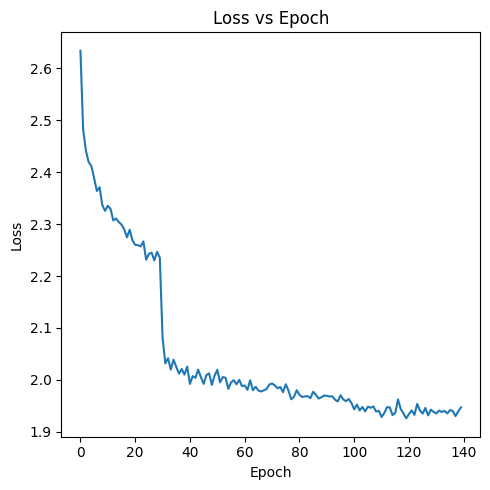

In [17]:
avg_loss: Tensor = (
    torch.tensor(losses_all, dtype=torch.float32).view(-1, 1_000).mean(dim=1)
)


fig, ax = plt.subplots(figsize=(5, 5))  # Create figure and axes
ax.plot(avg_loss)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

In [18]:
# Sample from the model (Untrained model!)
g = torch.Generator().manual_seed(5)
n_names: int = 20

# Set the training mode to False
for layer in model.layers:
    if hasattr(layer, "training"):
        layer.training = False


for _ in range(n_names):

    out: list[str] = []
    context: list[int] = [0] * block_size  # initialize with all ...
    while True:
        # Forward pass the neural net
        x: Tensor = torch.tensor([context])
        logits: Tensor = model(x)
        probs: Tensor = F.softmax(logits, dim=1)

        # Sample from the distribution
        idx: int = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # If we sample the special '.' token, break
        if idx == 0:
            break

    # Decode and print the generated word
    print("".join(num_to_text.get(i) for i in out))

karyi.
zipman.
esma.
gamelle.
shrith.
hadley.
alysen.
mikioa.
medan.
ducce.
arysees.
kodi.
terriya.
noam.
codecis.
zahaan.
talil.
sidnova.
siyon.
gilis.
